In [1]:
import pickle
import pandas as pd
import gzip
import os
import mne

from sklearn.decomposition import FastICA, PCA
from sklearn.preprocessing import MinMaxScaler
import mne
import os
import matplotlib
from tensorflow import keras
import natsort
import numpy as np
from sklearn.decomposition import PCA

In [2]:
filepath = []
for (path, dir, files) in os.walk("E:\MDD_BDI"):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.set':
            filepath.append("%s\%s" % (path, filename))

In [3]:
Prob_file = []
for file in filepath:
    if "Proba" in file:
        Prob_file.append(file)
Prob_file[:10]

['E:\\MDD_BDI\\sub-001\\eeg\\sub-001_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-002\\eeg\\sub-002_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-003\\eeg\\sub-003_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-004\\eeg\\sub-004_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-005\\eeg\\sub-005_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-006\\eeg\\sub-006_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-007\\eeg\\sub-007_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-008\\eeg\\sub-008_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-009\\eeg\\sub-009_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-010\\eeg\\sub-010_task-ProbabilisticSelection_eeg.set']

In [4]:
channels = ['FP1', 'FP2',
 'F7', 'F3', 'FZ', 'F4', 'F8',
 'T7', 'C3', 'CZ', 'C4', 'T8',
 'P7', 'P3', 'PZ', 'P4', 'P8',
 'O1', 'O2',
]

In [5]:
seg_unit = 512 * 10

In [6]:
"""
y = []
dataframes = []
for i in range(len(Prob_file)):
    temp = mne.io.read_raw_eeglab(Prob_file[i])
    temp = temp.to_data_frame()
    temp = temp[channels]

    MinMax = MinMaxScaler()
    X = MinMax.fit_transform(temp)

    ica = FastICA()
    S_ = ica.fit_transform(X)
    for k in range(50):
        sliced_data = S_[k*seg_unit : (k+1)*seg_unit]

        dataframes.append(pd.DataFrame(sliced_data, columns=channels))
"""

'\ny = []\ndataframes = []\nfor i in range(len(Prob_file)):\n    temp = mne.io.read_raw_eeglab(Prob_file[i])\n    temp = temp.to_data_frame()\n    temp = temp[channels]\n\n    MinMax = MinMaxScaler()\n    X = MinMax.fit_transform(temp)\n\n    ica = FastICA()\n    S_ = ica.fit_transform(X)\n    for k in range(50):\n        sliced_data = S_[k*seg_unit : (k+1)*seg_unit]\n\n        dataframes.append(pd.DataFrame(sliced_data, columns=channels))\n'

In [7]:
with gzip.open('data10sec.pickle','rb') as f:
    dataframes = pickle.load(f)

with gzip.open('C:\ARK\eeg\EEG_BDI\y10sec.pickle','rb') as f:
    y = pickle.load(f)

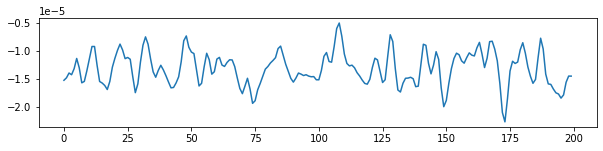

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,2))
temp = dataframes[0]
plt.plot(temp['FP1'][:200])

In [9]:
len(dataframes), len(y)
new_x = []
new_y = []
for i in range(len(dataframes)):
    if len(dataframes[i]) == 5120:
        new_x.append(dataframes[i])
        new_y.append(y[i])

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.2, random_state = 1)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

np.nan_to_num(y_train, copy=False)
np.nan_to_num(y_test, copy=False)



print(X_train.shape)
print(y_train.shape)
print(X_test.shape)


(4879, 5120, 19)
(4879,)
(1220, 5120, 19)


In [11]:
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, Dense, Flatten, Dropout, BatchNormalization, Reshape, LeakyReLU, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import os



In [12]:
from tensorflow.keras import layers
model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2560, 32)          4288      
_________________________________________________________________
dropout (Dropout)            (None, 2560, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1280, 16)          3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 2560, 16)          1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2560, 16)          0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 5120, 32)          3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 5120, 1)           2

In [13]:
history = model.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1
)

Epoch 1/50
69/69 [==============================] - 52s 232ms/step - loss: 1.6627e-06 - val_loss: 1.0110e-06